In [1]:
# %env PYTORCH_ENABLE_MPS_FALLBACK=1
%load_ext autoreload
%autoreload

from bins import Bins
from utils import calcOneChi2, HistMaker_1d, diffHist, setOPT_text
from ROOT import TFile, TH1, TH3F, TF2, TF1, TCanvas, TStyle, gStyle, Form, Fit, TLegend
import scipy.optimize as opt
import math
import calendar, os
from time import time, gmtime

Welcome to JupyROOT 6.28/04


In [2]:
read_saved = True
range_used = range(0,12)

if read_saved:
    DIR_NAME = "results_sameevt_nu15_noise1em1_1d"
else:
    current_GMT =   gmtime()
    time_stamp = calendar.timegm(current_GMT)
    DIR_NAME = f'results_{time_stamp}'
    os.mkdir(DIR_NAME)

In [3]:
bins = Bins.readFrom("ranges.yml")
#histMakerData_np = HistMaker_1d("apr12_diele_088_090_ag123ag_2500A_accepted_np_mix_hc_sample_2.dat", "_data", bins)
histMakerData_np = HistMaker_1d("apr12_diele_088_090_ag123ag_2500A_accepted_np_2.dat", "_data_np", bins)
histsData_np = histMakerData_np.makeHists()
histMakerData_pp = HistMaker_1d("apr12_diele_088_090_ag123ag_2500A_accepted_pp_2.dat", "_data_pp", bins)
histsData_pp = histMakerData_pp.makeHists()
histMakerData_nn = HistMaker_1d("apr12_diele_088_090_ag123ag_2500A_accepted_nn_2.dat", "_data_nn", bins)
histsData_nn = histMakerData_nn.makeHists()
histMakerMC_rho = HistMaker_1d("mar19_diele_inmedium_heli0cm_np.dat", "_MC_rho", bins)
histMakerMC_pi0 = HistMaker_1d("mar19_diele_pi0_heli0cm_np.dat", "_MC_pi0", bins)
def getHistMakerMC(HIST_INDEX):
    return histMakerMC_pi0 if HIST_INDEX < 3 else histMakerMC_rho
   # return histMakerMC_rho


iter 0
#1 [[<cppyy.gbl.TH1F object at 0x15354d100>, <cppyy.gbl.TH1F object at 0x15354d4f0>, <cppyy.gbl.TH1F object at 0x15354d8e0>, <cppyy.gbl.TH1F object at 0x15354dcd0>, <cppyy.gbl.TH1F object at 0x15354e0c0>, <cppyy.gbl.TH1F object at 0x15354e4b0>, <cppyy.gbl.TH1F object at 0x15354e8a0>, <cppyy.gbl.TH1F object at 0x15354ec90>, <cppyy.gbl.TH1F object at 0x15354f080>, <cppyy.gbl.TH1F object at 0x15354f470>, <cppyy.gbl.TH1F object at 0x15354f860>, <cppyy.gbl.TH1F object at 0x15354fc50>], [<cppyy.gbl.TH1F object at 0x153550040>, <cppyy.gbl.TH1F object at 0x153550820>], [<cppyy.gbl.TH1F object at 0x153550430>, <cppyy.gbl.TH1F object at 0x153550c10>]]
#2 [[<cppyy.gbl.TH1F object at 0x153554010>, <cppyy.gbl.TH1F object at 0x153554400>, <cppyy.gbl.TH1F object at 0x1535547f0>, <cppyy.gbl.TH1F object at 0x153554be0>, <cppyy.gbl.TH1F object at 0x153554fd0>, <cppyy.gbl.TH1F object at 0x1535553c0>, <cppyy.gbl.TH1F object at 0x1535557b0>, <cppyy.gbl.TH1F object at 0x153555ba0>, <cppyy.gbl.TH1F ob

Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/base_hists_pi0_MC.gif has been created


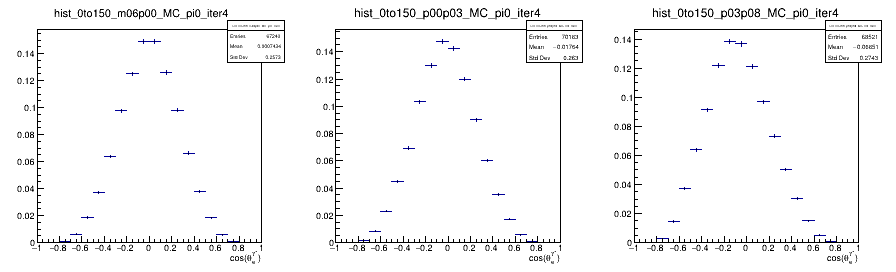

In [4]:
base_hists_pi0 = histMakerMC_pi0.builder.base_hists
can3 = TCanvas("can3","can3",900,300)
can3.Divide(3,1)
can3.Draw()
for i, hist in enumerate(base_hists_pi0[0]):
    if i < 3:
        can3.cd(i+1)
        if not isinstance(hist, list):
            hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
            hist.Draw()
        else:
            print(hist)
can3.SaveAs(f"{DIR_NAME}/base_hists_pi0_MC.gif")

Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/base_hists_rho_MC.gif has been created


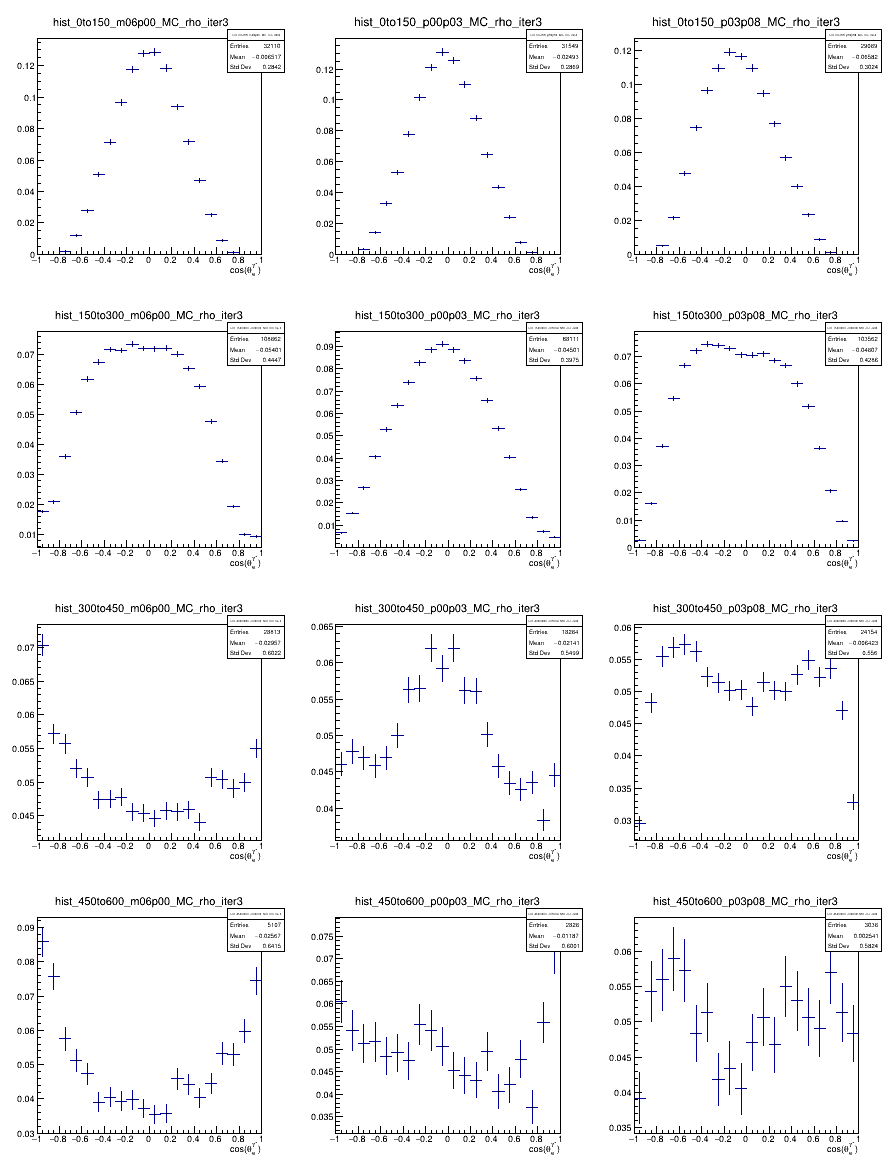

In [5]:
base_hists_rho = histMakerMC_rho.builder.base_hists
can5 = TCanvas("can5","can5",900,1200)
can5.Divide(3,4)
can5.Draw()
for i, hist in enumerate(base_hists_rho[0]):
    can5.cd(i+1)
    if not isinstance(hist, list):
        hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        hist.Draw()
    else:
        print(hist)
can5.SaveAs(f'{DIR_NAME}/base_hists_rho_MC.gif')


Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/histsData_np.gif has been created


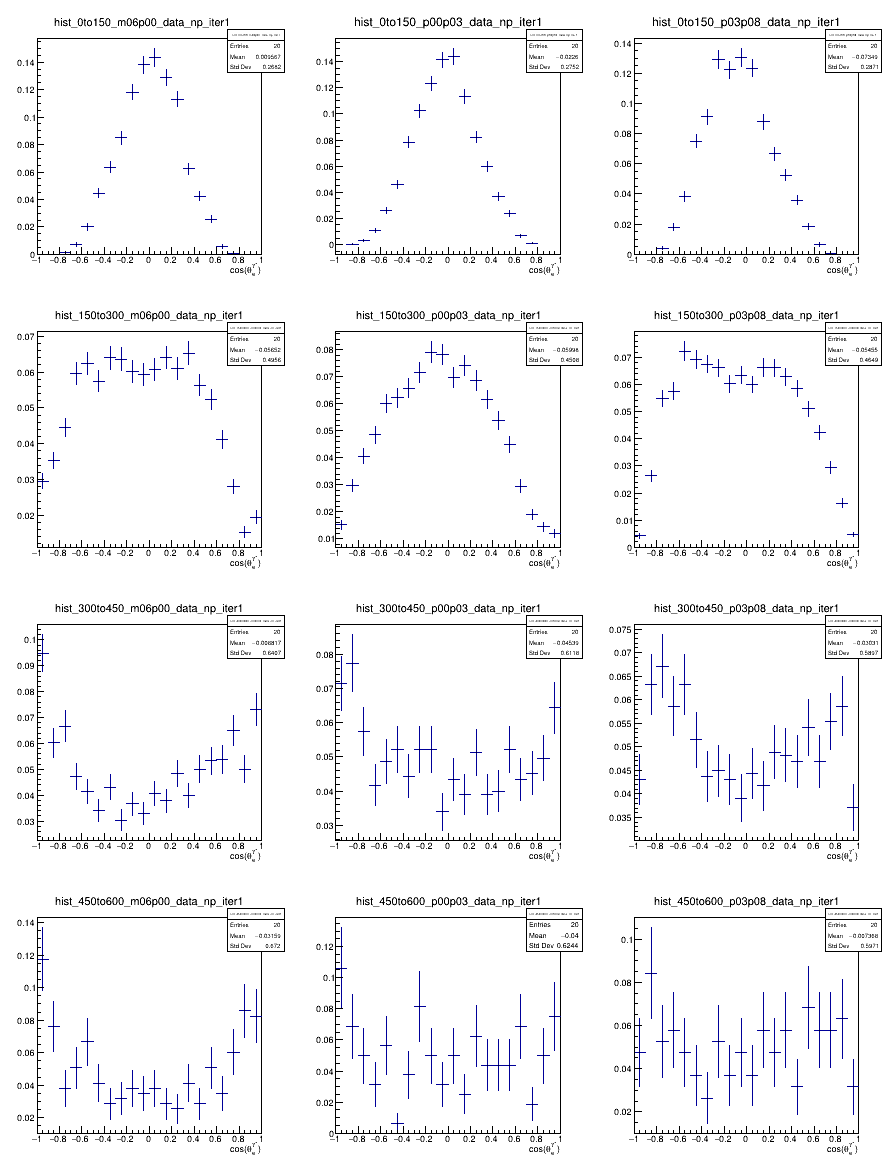

In [6]:
can4 = TCanvas("can4","can4",900,1200)
can4.Divide(3,4)
can4.Draw()
for i, hist in enumerate(histsData_np[0]):
    can4.cd(i+1)
    if not isinstance(hist, list):
        hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        hist.Draw("COLZ")
    else:
        print(hist)

can4.SaveAs(f'{DIR_NAME}/histsData_np.gif')

In [7]:
import torch

torch.device("mps")
torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm

import warnings

In [8]:
TH1.SetDefaultSumw2

gpytorch.settings.fast_pred_var()
gpytorch.settings.fast_pred_samples()

N_PARAMS = 1

In [9]:
torch.backends.mps.is_available()
#mps_device = torch.device("mps")
mps_device = torch.device("cpu")
bounds = torch.tensor([[-1, ],
                       [ 1, ]], dtype=torch.float)
bounds = bounds.to(mps_device)


xs = torch.linspace(bounds[0][0], bounds[1][0], 101)

In [10]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
# class GPModel(gpytorch.models.ApproximateGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=1)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        mean_x = mean_x.to(mps_device)
        covar_x = covar_x.to(mps_device)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp_model(train_x, train_y, num_train_iters=500):
    train_x = train_x.to(mps_device)
    train_y = train_y.to(mps_device)

    # declare the GP
    noise = 1e-1

    likelihood = gpytorch.likelihoods.StudentTLikelihood()
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise
    likelihood = likelihood.to(mps_device)
    model = model.to(mps_device)

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model.cpu(), likelihood.cpu()

In [11]:
# TODO: Come back to standard version
#num_queries = 75
num_queries = 200
num_repeats = 1
num_samples = 20

In [12]:
# -2 is the default value when no feasible has been found
default_value = -1

def fit_bo(HIST_INDEX = 0):
    global bounds

    def objective(xx):
        def generator(xx):
            for x in xx:
                lambda_theta = x

                histsMC = getHistMakerMC(HIST_INDEX).makeHists(lambda_theta)
                chi2, ndf = calcOneChi2(histsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX])
                allHistsMC.append(histsMC[0][HIST_INDEX])
                if not chi2 or not ndf:
                    return torch.tensor([0])
                yield torch.tensor([1.0/(chi2 / ndf)])
        return torch.stack([a for a in generator(xx)])

    def one_starting_sample():
        result = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(N_PARAMS)
        return result

    feasible_incumbents = torch.ones((num_repeats, num_queries)) * default_value

    best_fs = []

    print(f"HIST INDEX: {HIST_INDEX}")
    for trial in range(num_repeats):
       # print("trial", trial)

        torch.manual_seed(trial)
       # train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
       # while -2.0*train_x[0][0] - 1.0*train_x[0][2] < -2:
       #     train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
        train_x = torch.stack([one_starting_sample() for _ in range(num_samples)])
        train_utility = objective(train_x).to(mps_device)
        train_x = train_x.to(mps_device)

        for i in tqdm(range(num_queries)):
            feasible_incumbents[trial, i] = train_utility.max()
            before_fit_gp = time()
            utility_model, utility_likelihood = fit_gp_model(
                train_x, train_utility.squeeze(-1)
            )
            after_fit_gp = time()
           # print("Fitting GP took " + str(after_fit_gp - before_fit_gp) + " seconds")
            best_f = train_utility.max()
            best_fs.append(best_f.item())
                
           # policy = botorch.acquisition.monte_carlo.qExpectedImprovement(
           # policy = botorch.acquisition.analytic.LogExpectedImprovement(
            policy = botorch.acquisition.logei.qLogExpectedImprovement(
          # policy = botorch.acquisition.analytic.LogProbabilityOfImprovement(
          # policy = botorch.acquisition.analytic.PosteriorMean(
                model=utility_model,
                best_f=train_utility.max(),
            ).to(mps_device)

            before_optimize_acqf = time()
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=RuntimeWarning)
                next_x, acq_val = botorch.optim.optimize_acqf(
                    policy,
                    bounds=bounds,
                    #q=5,
                    #num_restarts=5,
                    #raw_samples=400,
                    q=1,
                    num_restarts=40,
                    raw_samples=100,
                )
            after_optimize_acqf = time()
           # print("Optimizing ACQF took " + str(after_optimize_acqf - before_optimize_acqf) + " seconds")

            next_utility = objective(next_x).to(mps_device)

            train_x = torch.cat([train_x, next_x])
            train_utility = torch.cat([train_utility, next_utility])
    torch.save(feasible_incumbents, f"{DIR_NAME}/incumbents_" + str(HIST_INDEX) + ".pth")
    fout = TFile(f"{DIR_NAME}/out_{HIST_INDEX}.root","RECREATE")
    fout.cd()
    for hist in allHistsMC:
       # print ("Writing hist: ", hist.GetName())
        hist.Write()
    for j, hists in enumerate(histsData_np):
        for k, hist in enumerate(hists):
                hist.Write()
               # print ("Writing hist: ", j, k, hist)
    fout.Close()

    with torch.no_grad():
        predictive_distribution = utility_likelihood(utility_model(xs))
        acquisition_score = policy(xs.unsqueeze(1))

    lambda_thetas     = train_x.flatten()
    
    c = torch.stack((
        torch.arange(0,num_queries, dtype=int),
        lambda_thetas[0:num_queries],
        train_utility.squeeze()[0:num_queries],
        (feasible_incumbents==feasible_incumbents.max())[0],
        feasible_incumbents[0]
    ),0).transpose(-2,-1)
    torch.set_printoptions(precision=4,threshold=10_000, linewidth=120)
    sort_index = c[:, N_PARAMS + 1].sort()[1]
    c_sorted = c[sort_index]
    train_x_sorted = train_x[sort_index]

    return c_sorted, train_x_sorted, predictive_distribution

In [13]:
c_sorted_all = []
train_x_sorted_all = []
predictive_mean_all = []
predictive_lower_all = []
predictive_upper_all = []

for HIST_INDEX in range_used:
    allHistsMC = []
    if read_saved:
        c_sorted = torch.load(f"{DIR_NAME}/c_sorted_" + str(HIST_INDEX) + ".pth")
        train_x_sorted = torch.load(f"{DIR_NAME}/train_x_sorted_" + str(HIST_INDEX) + ".pth")
        predictive_distribution = torch.load(f"{DIR_NAME}/predictive_distribution_" + str(HIST_INDEX) + ".pth")

        file = TFile(f"{DIR_NAME}/out_{HIST_INDEX}.root", "read")
        names = [key.GetName() for key in file.GetListOfKeys()]
        names = [name for name in names if "MC" in name]
        for name in names:
            allHistsMC.append(file.Get(name))
    else:
        c_sorted, train_x_sorted, predictive_distribution = fit_bo(HIST_INDEX)
        print(c_sorted[-5:])
        
        torch.save(c_sorted, f"{DIR_NAME}/c_sorted_" + str(HIST_INDEX) + ".pth")
        torch.save(train_x_sorted, f"{DIR_NAME}/train_x_sorted_" + str(HIST_INDEX) + ".pth")
        torch.save(predictive_distribution, f"{DIR_NAME}/predictive_distribution_" + str(HIST_INDEX) + ".pth")

    predictive_mean = predictive_distribution.mean
    predictive_lower, predictive_upper = predictive_distribution.confidence_region()
    print("AFTER_READING: ", predictive_mean[100], predictive_lower[100], predictive_upper[100])

    c_sorted_all.append(c_sorted)
    train_x_sorted_all.append(train_x_sorted)
    predictive_mean_all.append(predictive_mean)
    predictive_lower_all.append(predictive_lower)
    predictive_upper_all.append(predictive_upper)



AFTER_READING:  tensor(0.5474) tensor(0.4794) tensor(0.6154)
AFTER_READING:  tensor(1.1300) tensor(1.0499) tensor(1.2101)
AFTER_READING:  tensor(0.9332) tensor(0.8643) tensor(1.0021)
AFTER_READING:  tensor(0.5425) tensor(0.4846) tensor(0.6003)
AFTER_READING:  tensor(0.5025) tensor(0.4446) tensor(0.5603)
AFTER_READING:  tensor(0.6322) tensor(0.5743) tensor(0.6901)
AFTER_READING:  tensor(0.5026) tensor(0.4256) tensor(0.5795)
AFTER_READING:  tensor(1.1193) tensor(1.0614) tensor(1.1773)
AFTER_READING:  tensor(1.1464) tensor(1.0642) tensor(1.2287)
AFTER_READING:  tensor(1.0135) tensor(0.9347) tensor(1.0923)
AFTER_READING:  tensor(0.3630) tensor(0.3055) tensor(0.4205)
AFTER_READING:  tensor(1.0279) tensor(0.8601) tensor(1.1956)


In [14]:
from ipywidgets import interact, Layout, IntSlider, FloatSlider
import numpy as np

axis_title = r"$cos(\theta_e^{\gamma*})$"

def oneplot(ax, tensor, title):
        
        global xs
        
       # pos = ax.plot(xs, tensor, ymin=0, ymax=tensor.max())
        pos = ax.plot(xs, tensor)
       # ax.set_aspect((extent[1]-extent[0])/(extent[3]-extent[2]))
        ax.set_title(title)
        ax.set_xlabel(axis_title)

# def f(ax):
#        return oneplot(ax, predictive_mean, r"ndf$/\chi^2$")

gStyle.SetOptStat(0)

can_cmp_ind = 0

def plotComparison(can, pad_nr1, pad_nr2, histMC, histData, hist_index, pull_title):
   # print(f"PLOTTING: {histMC.GetName()} and {histData.GetName()}")
    global can_cmp_ind

    curr_bin = bins[hist_index]
    title = f"{curr_bin.m_min} < #it{{M}}_{{ee}} < {curr_bin.m_max}, {curr_bin.z_min} < cos(#theta^{{CM}}_{{#gamma*}}) < {curr_bin.z_max}"
    
    pad = can.cd(pad_nr1)
    pad.SetRightMargin(0.16)
    histData.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
    histData.SetTitle(title)
    histData.Draw()
    histMC.SetLineColor(2)
    histMC.Draw("SAMEHIST")
    pad = can.cd(pad_nr2)
    pad.SetRightMargin(0.16)
    hdiff = diffHist(histMC, histData)
    hdiff.SetTitle(pull_title)
    hdiff.GetYaxis().SetTitle("Pull value")
    hdiff.Draw("HIST")
    can.Update()
    can.Modified()
    can.Update()
    
    return hdiff

In [15]:
def bin_index(x, min, max):
        return int((x-min)/(max-min)*101)

def covariance_fit_scipy(predictive_mean, predictive_lower, predictive_upper, best, HIST_INDEX, ax):
    def gaus1d(x, A, mean_x, sigma_x):
        x = x - mean_x
        z = A * np.exp( -0.5 * (x/sigma_x) ** 2 )
        return z
    def gaus1d_offset(x, A, mean_x, sigma_x, offset):
        x = x - mean_x
        z = offset + A * np.exp( -0.5 * (x/sigma_x) ** 2 )
        return z

    def fit_1d(ax):
        curr_bin = bins[HIST_INDEX]
        title = f"{curr_bin.m_min} < $M_{{ee}}$ < {curr_bin.m_max}, {curr_bin.z_min} < $cos(\\theta^{{CM}}_{{\gamma*}})$ < {curr_bin.z_max}"
        
        mean_x = best[0].item()

        scale1 = bounds[1][0].item()
        scale2 = bounds[1][0].item()
        proj_min_X = bounds[0][0].item()
        proj_max_X = bounds[1][0].item()

        proj = predictive_mean
        proj_lower = predictive_lower
        proj_upper = predictive_upper

       # xmin_ind = max(0,   bin_index(mean_x, proj_min_X, proj_max_X)-50)
       # xmax_ind = min(100, bin_index(mean_x, proj_min_X, proj_max_X)+50)
        xmin_ind = 0
        xmax_ind = 100
        xmin = proj_min_X + xmin_ind / 101. * (proj_max_X - proj_min_X)
        xmax = proj_min_X + (xmax_ind + 1) / 101. * (proj_max_X - proj_min_X)

        x = np.linspace(-1, 1, 101)

        proj1 = proj[xmin_ind:xmax_ind]
        print("range ", xmin_ind, xmax_ind, xmin, xmax)
    
       # initial_guess = (1.0, mean_x, 0.2*(proj_max_X-proj_min_X))
        initial_guess = (1.0, mean_x, 0.2*(proj_max_X-proj_min_X), 0)
        eps = 0.001
       # param_bounds = ([0,mean_x-eps,0],[np.inf,mean_x+eps,2])
       # if mean_x >= 1.0:
       #     param_bounds = ([0,mean_x-eps,0],[np.inf,2,2])
        param_bounds = ([0,mean_x-eps,0,-np.inf],[np.inf,mean_x+eps,2,np.inf])
        if mean_x >= 1.0:
            param_bounds = ([0,mean_x-eps,0,-np.inf],[np.inf,2,2,np.inf])
        ax.plot(x, proj, label="Estimated values")
        ax.fill_between(x, proj_lower, proj_upper, alpha=0.5)
        ax.plot(x, proj, label="Estimated values")
        ax.set_title(title)
        ax.set_xlabel(r"$\lambda_{\theta}$")
        ax.set_ylabel("ndf$/\chi^2$")
        try:
            popt, pcov = opt.curve_fit(gaus1d_offset, x[xmin_ind:xmax_ind], proj1, p0 = initial_guess, bounds=param_bounds, maxfev=2000)
            fit_result = gaus1d_offset(x, *(popt))
    
            ax.plot(x, fit_result, label="Gaussian fit")
            ax.set_ylim([0,1.5*predictive_upper.max()])
            ax.legend()
        except RuntimeError as e:
            print(f"There was an exception {e}")
            popt, pcov = None, None
        return popt, pcov

   # params0, _ = fit_1d(ax[1][0])
    params0, _ = fit_1d(ax)
    plt.savefig(f"{DIR_NAME}/chi2_best_{HIST_INDEX}.png", bbox_inches="tight")

    try:
        return params0[2]
    except:
        return None

#2 [[<cppyy.gbl.TH1F object at 0x2c8479fb0>, <cppyy.gbl.TH1F object at 0x2c847a3a0>, <cppyy.gbl.TH1F object at 0x2c847a790>, <cppyy.gbl.TH1F object at 0x2c847ab80>, <cppyy.gbl.TH1F object at 0x2c847af70>, <cppyy.gbl.TH1F object at 0x2c847b360>, <cppyy.gbl.TH1F object at 0x2c847b750>, <cppyy.gbl.TH1F object at 0x2c847bb40>, <cppyy.gbl.TH1F object at 0x2c847bf30>, <cppyy.gbl.TH1F object at 0x2c847c320>, <cppyy.gbl.TH1F object at 0x2c847c710>, <cppyy.gbl.TH1F object at 0x2c847cb00>], [<cppyy.gbl.TH1F object at 0x153561bd0>, <cppyy.gbl.TH1F object at 0x1535623b0>], [<cppyy.gbl.TH1F object at 0x153561fc0>, <cppyy.gbl.TH1F object at 0x1535627a0>]]
#2 [[<cppyy.gbl.TH1F object at 0x169ae75f0>, <cppyy.gbl.TH1F object at 0x169ae79e0>, <cppyy.gbl.TH1F object at 0x169ae7dd0>, <cppyy.gbl.TH1F object at 0x169ae81c0>, <cppyy.gbl.TH1F object at 0x169ae85b0>, <cppyy.gbl.TH1F object at 0x169ae89a0>, <cppyy.gbl.TH1F object at 0x169ae8d90>, <cppyy.gbl.TH1F object at 0x169ae9180>, <cppyy.gbl.TH1F object at

Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_0.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_1.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_2.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_3.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_4.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_5.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_6.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_7.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_8.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comp

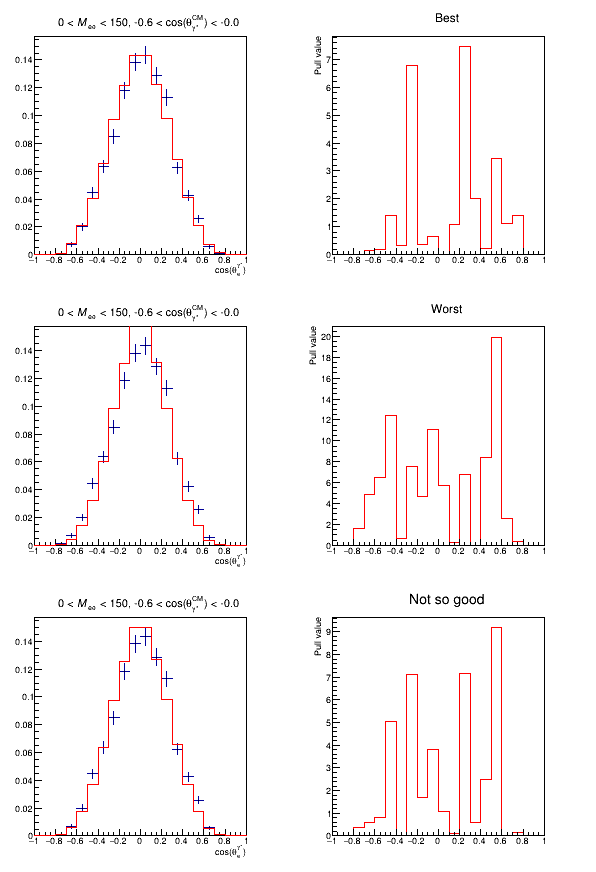

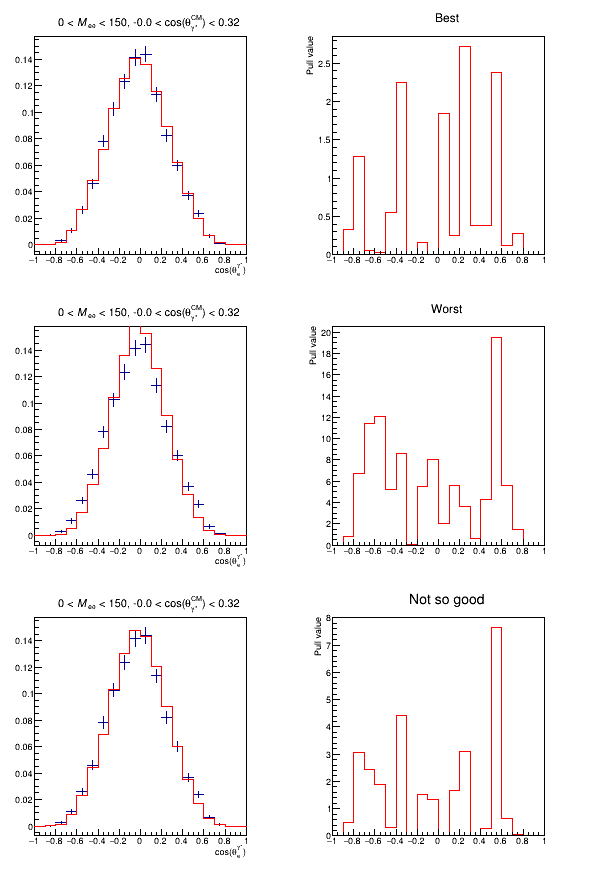

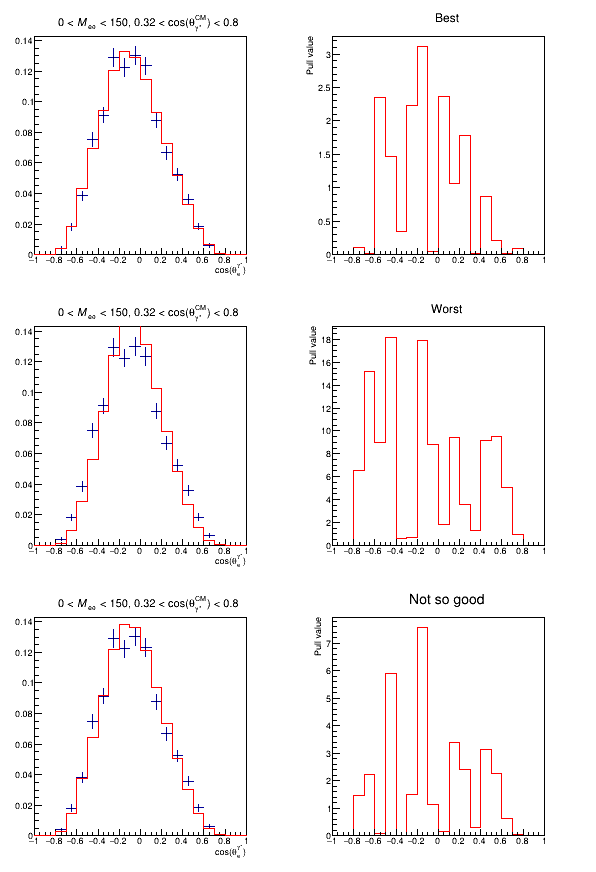

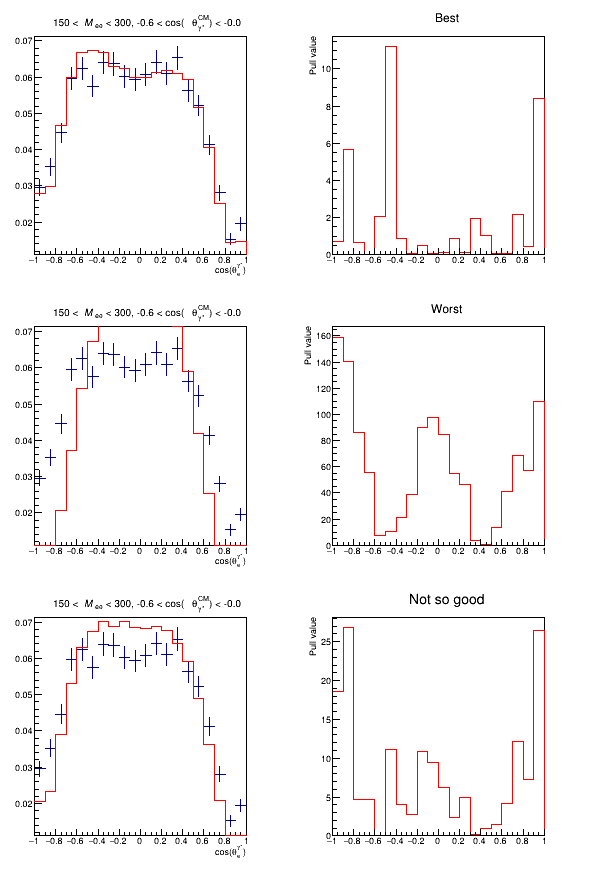

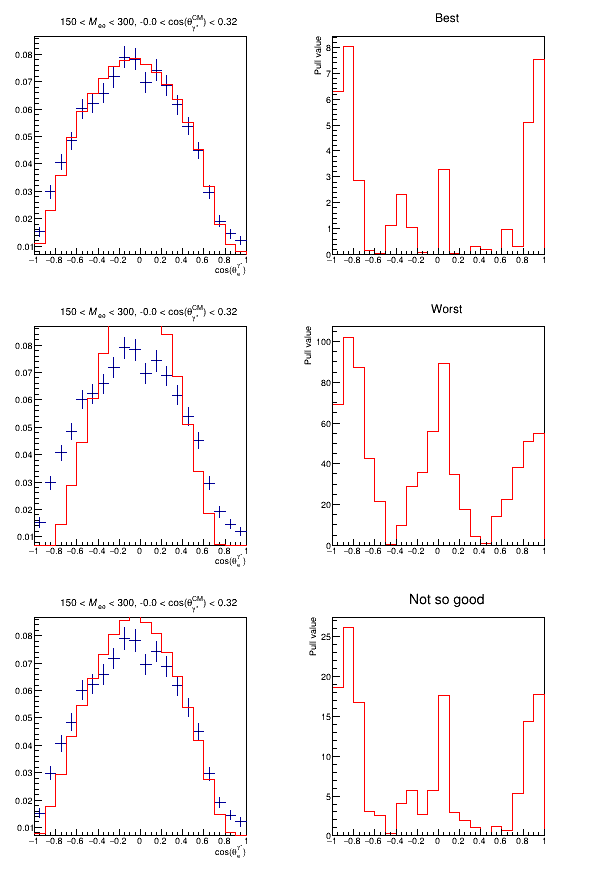

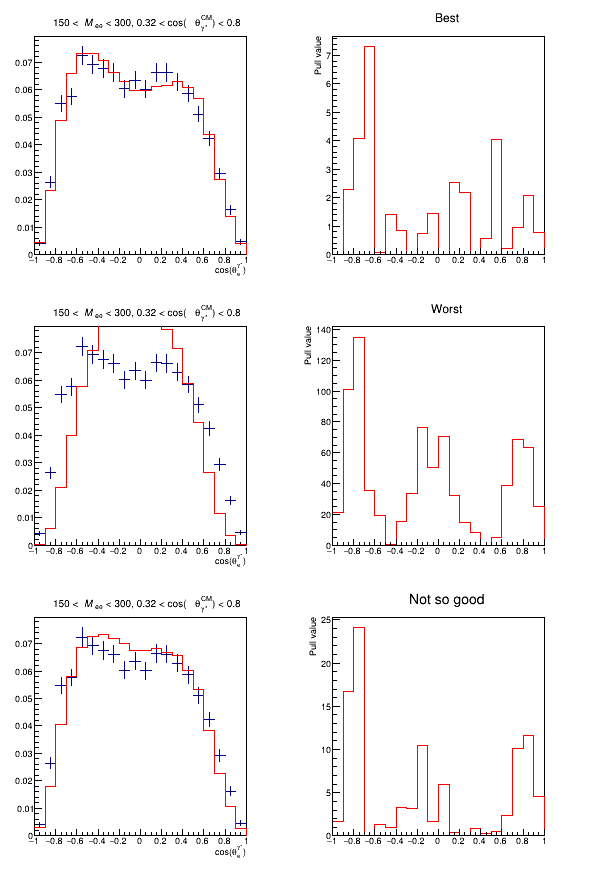

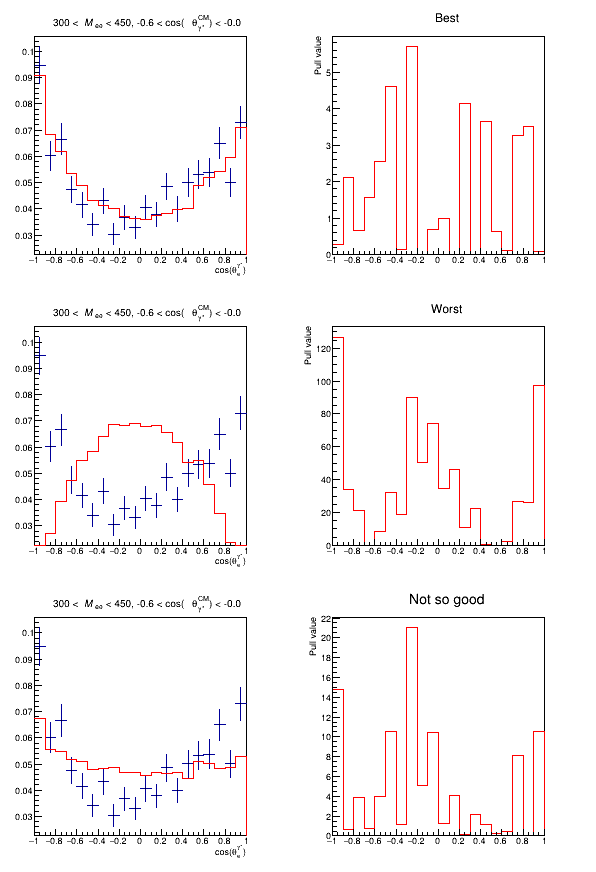

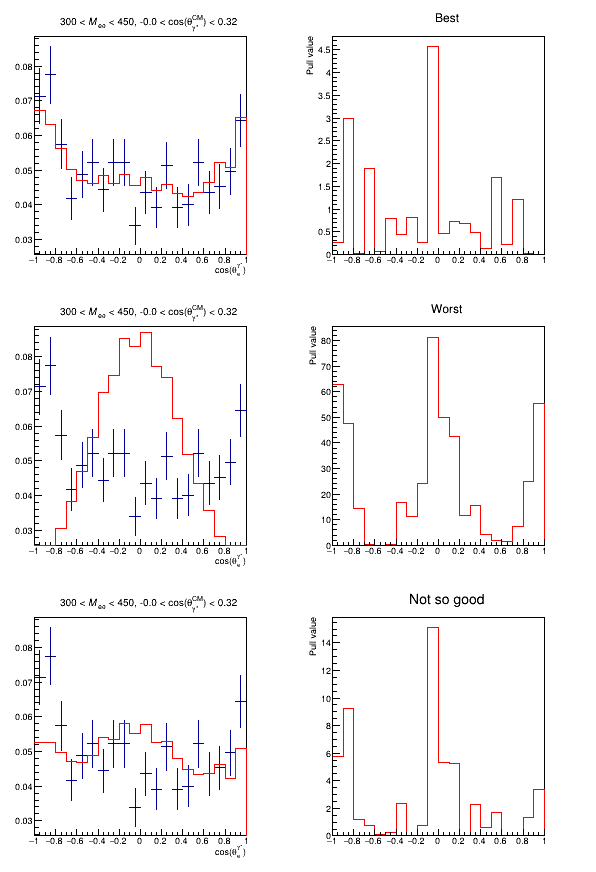

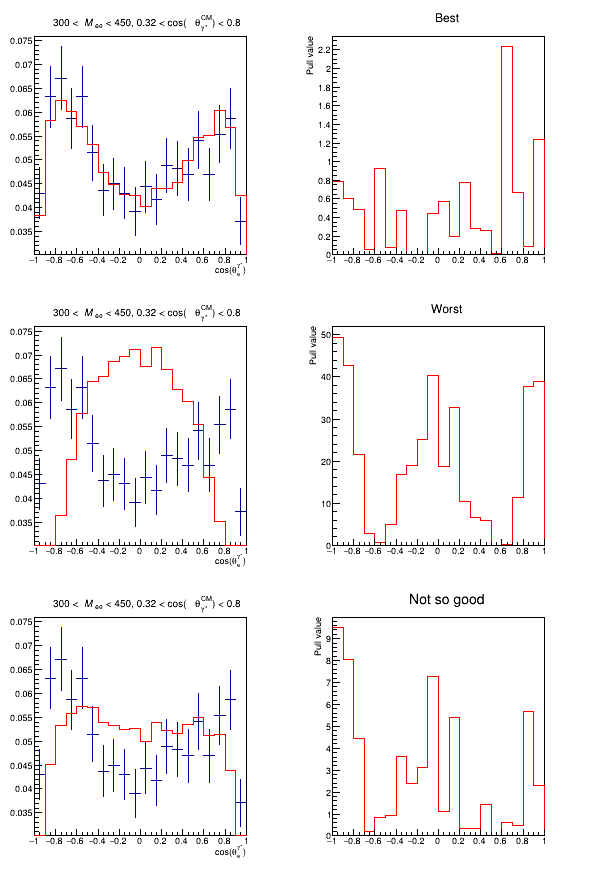

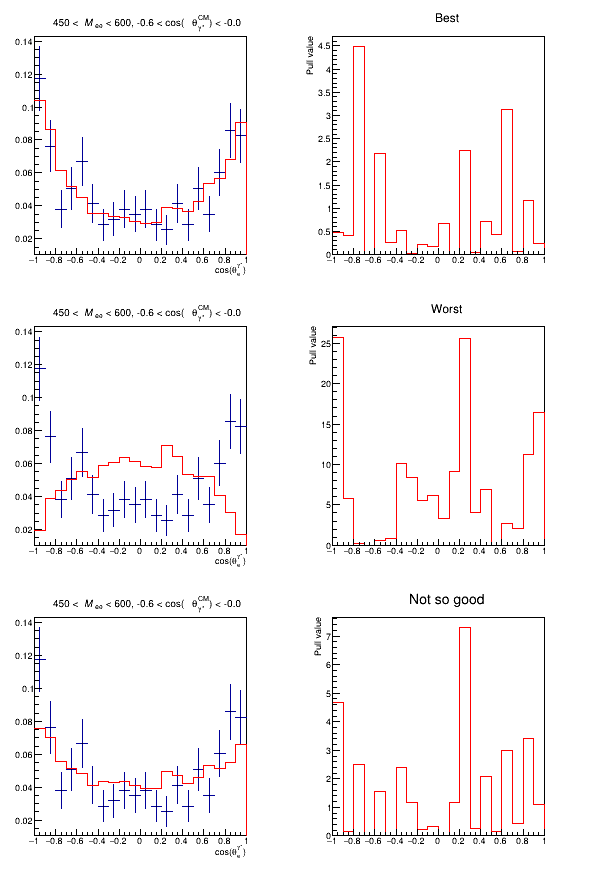

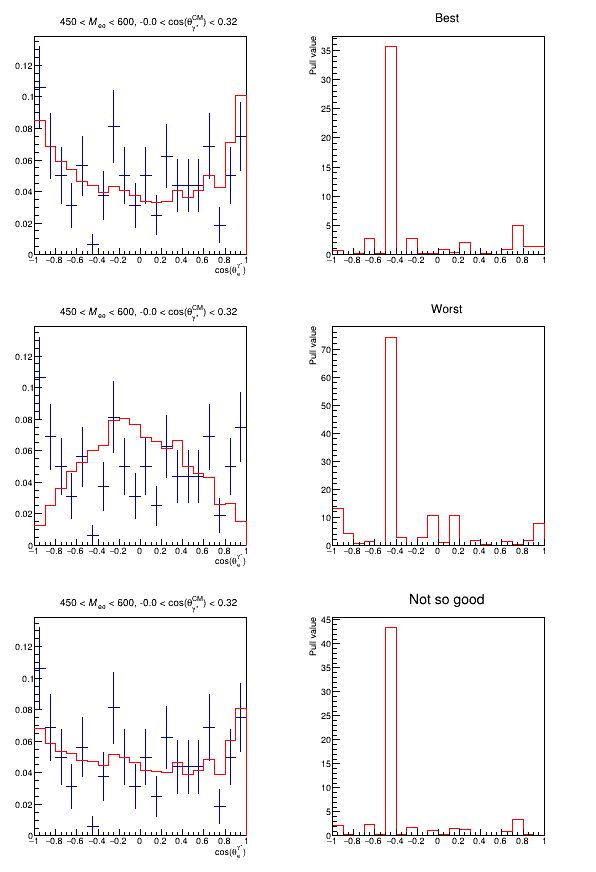

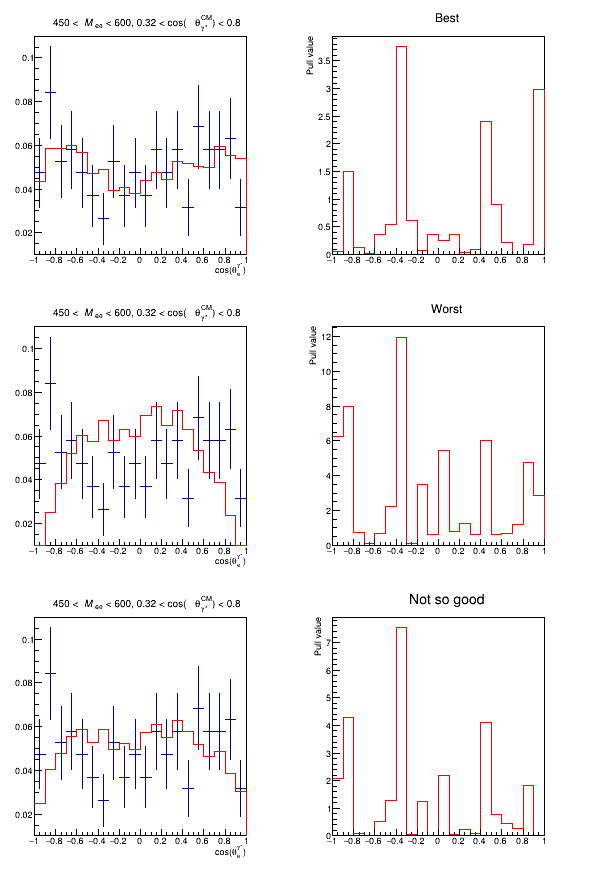

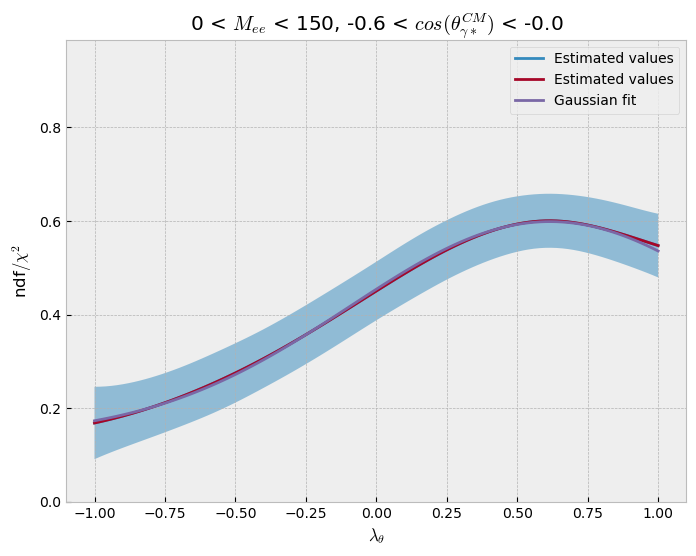

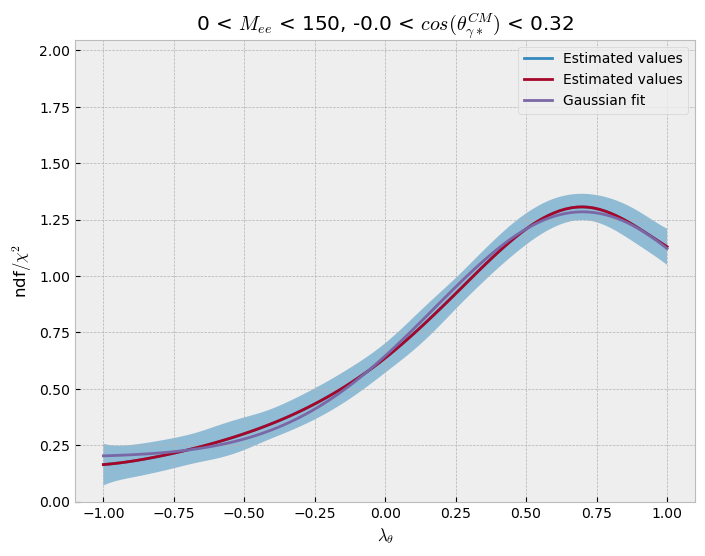

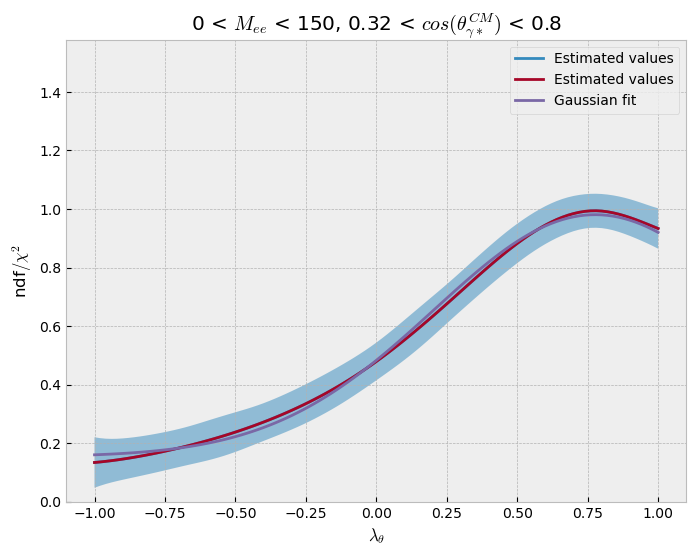

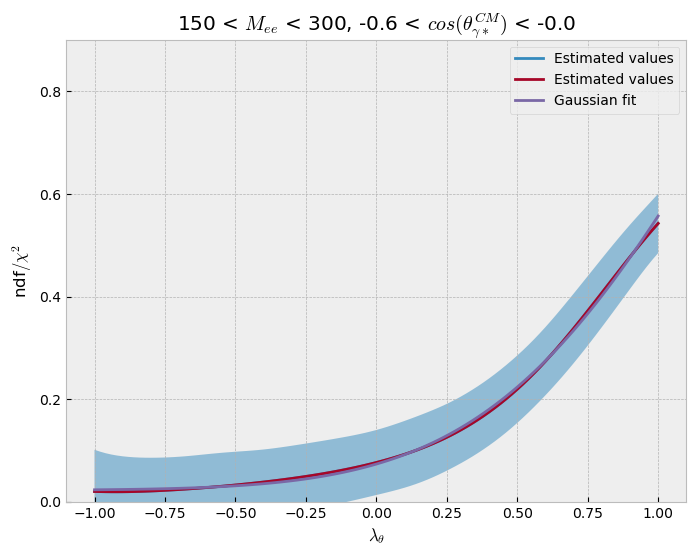

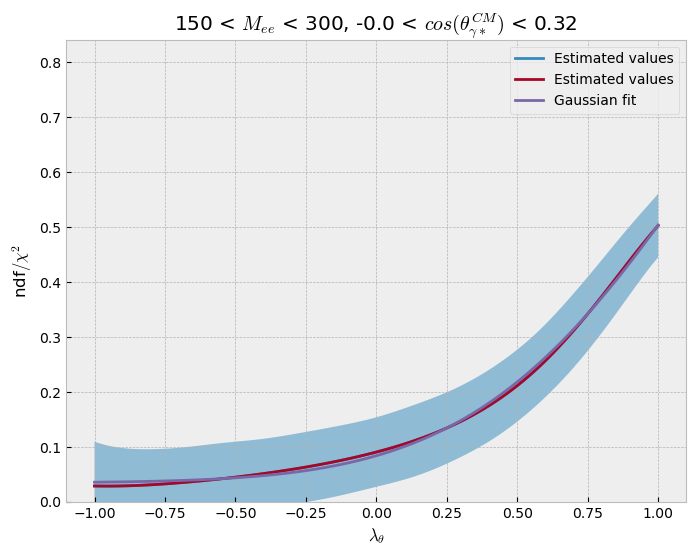

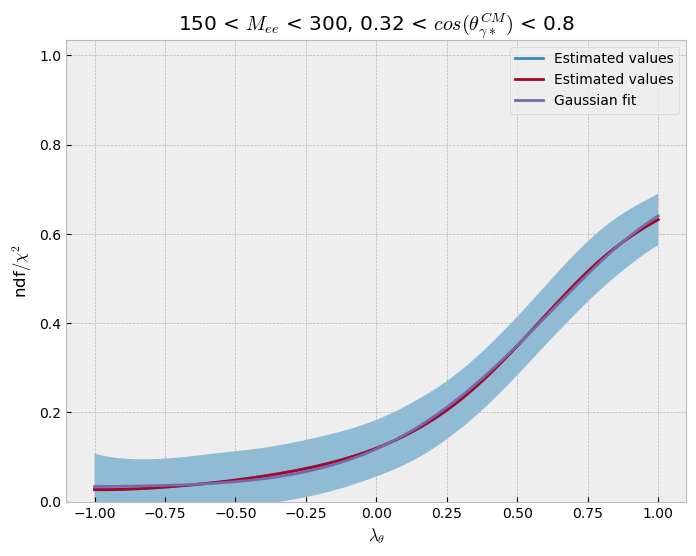

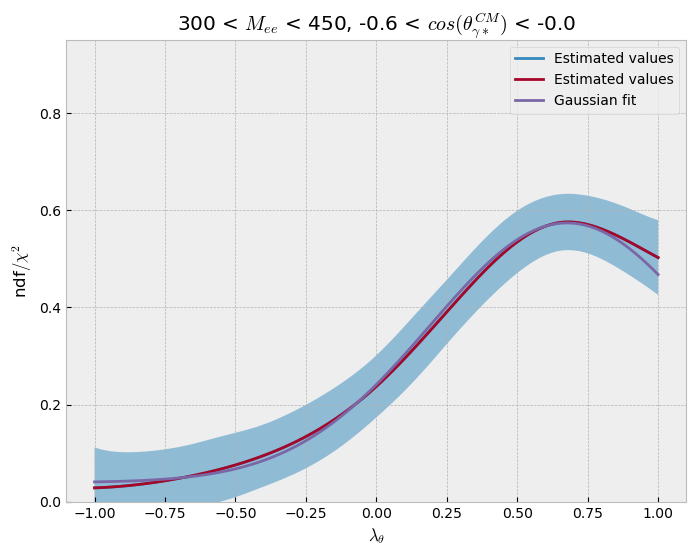

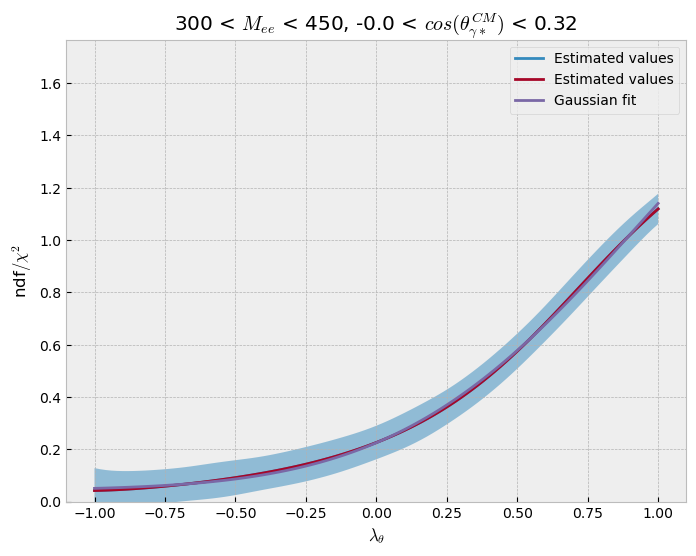

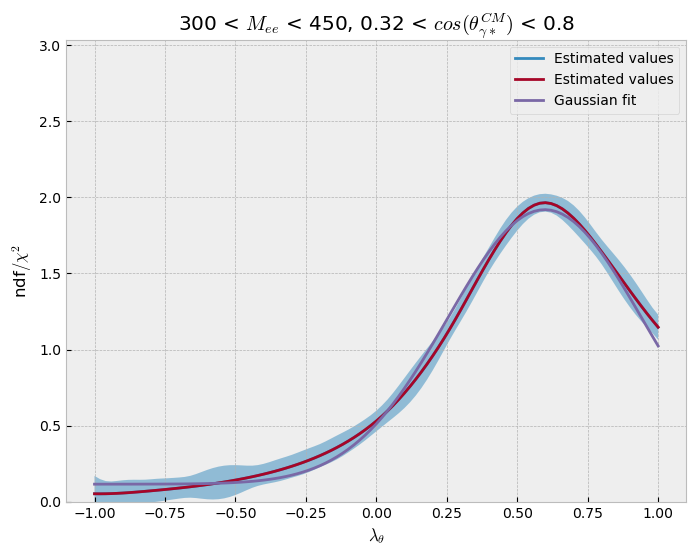

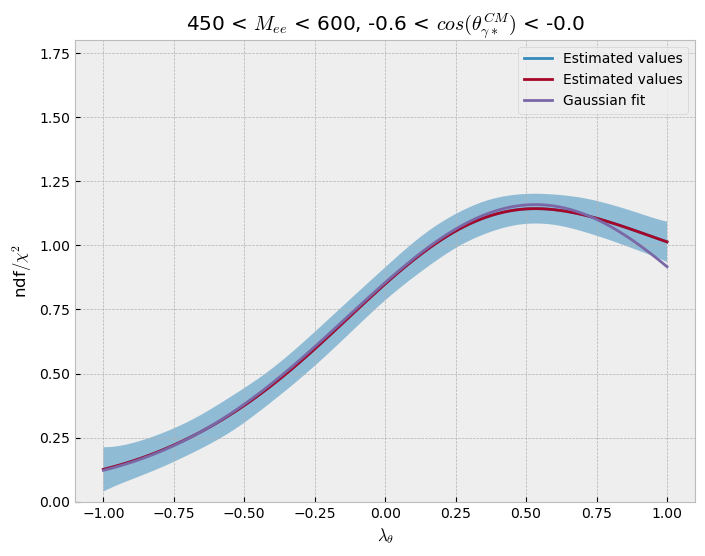

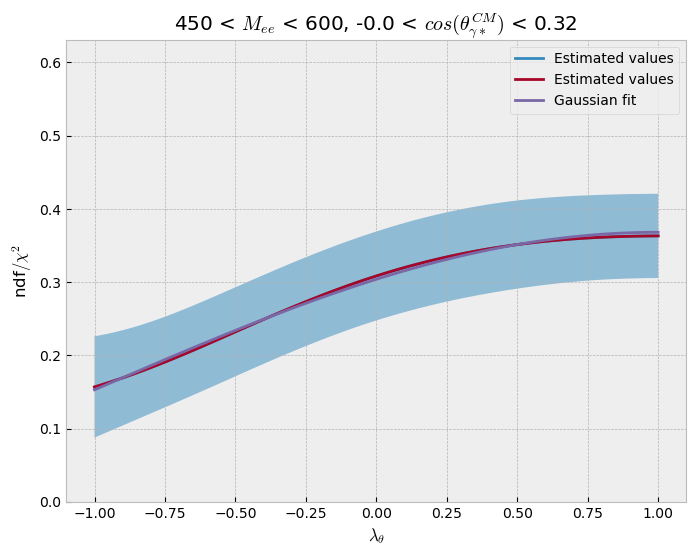

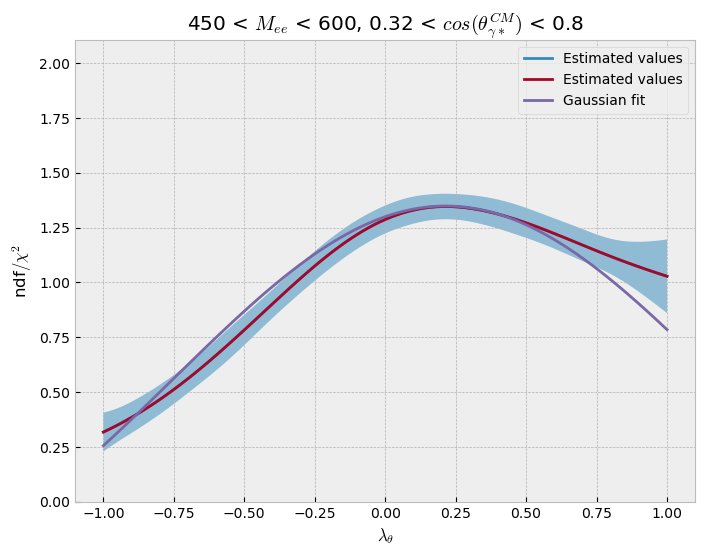

In [16]:

with open(f'{DIR_NAME}/results.txt', 'w') as fout:
    canvases = []
    hdiffs = []
    hmodels = []
    
    for HIST_INDEX in range_used:

        c_sorted = c_sorted_all[HIST_INDEX - range_used.start]
        train_x_sorted = train_x_sorted_all[HIST_INDEX - range_used.start]
        predictive_mean = predictive_mean_all[HIST_INDEX - range_used.start]
        predictive_lower = predictive_lower_all[HIST_INDEX - range_used.start]
        predictive_upper = predictive_upper_all[HIST_INDEX - range_used.start]
        predictive_mean_2 = predictive_mean - predictive_mean.min()

       # ax = plt.axes()
        fig, ax = plt.subplots(nrows=1, ncols=1)
        lambda_theta = train_x_sorted[-1]
        bestHistsMC = getHistMakerMC(HIST_INDEX).makeHists(lambda_theta)
        hmodels.append(bestHistsMC[0][HIST_INDEX])
        
        can1 = TCanvas(f"can_cmp_{HIST_INDEX}","can",600,900)
        can1.Divide(2,3)
        can1.Draw()        
        canvases.append(can1)
        
        hdiff1 = plotComparison(can1, 1, 2, bestHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX], HIST_INDEX, "Best")
        hdiffs.append(hdiff1)
        
        lambda_theta = train_x_sorted[0]
        worstHistsMC = getHistMakerMC(HIST_INDEX).makeHists(lambda_theta)
        hmodels.append(worstHistsMC[0][HIST_INDEX])
        hdiff2 = plotComparison(can1, 3, 4, worstHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX], HIST_INDEX, "Worst")
        hdiffs.append(hdiff2)

        shift = 0.75
        if train_x_sorted[-1] > shift - 1:
            diffToBest = torch.tensor([-shift])
        else:
            diffToBest = torch.tensor([+shift])
        lambda_theta = train_x_sorted[-1] + diffToBest
        notSoGoodHistsMC = getHistMakerMC(HIST_INDEX).makeHists(lambda_theta)
        hmodels.append(notSoGoodHistsMC[0][HIST_INDEX])
        hdiff22 = plotComparison(can1, 5, 6, notSoGoodHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX], HIST_INDEX, "Not so good")
        hdiffs.append(hdiff22)

        can1.SaveAs(f"{DIR_NAME}/comparison_{HIST_INDEX}.gif")

        print(str(HIST_INDEX) + ": Final result:")
        print(str(HIST_INDEX) + ": Final result:", file=fout)
        print(str(HIST_INDEX) + ": lambda_theta = ", c_sorted[-1][1].item())
        print(str(HIST_INDEX) + ": lambda_theta = ", c_sorted[-1][1].item(), file=fout)

        drphiz = covariance_fit_scipy(predictive_mean,predictive_lower,predictive_upper,train_x_sorted[-1],HIST_INDEX,ax)

        try:
            print(str(HIST_INDEX) + ": errors = ", drphiz)
            print(str(HIST_INDEX) + ": errors = ", drphiz, file=fout)
        except:
            print(str(HIST_INDEX) + ": errors could not be determined")
            print(str(HIST_INDEX) + ": errors could not be determined", file=fout)

Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_0.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_1.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_2.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_3.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_4.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_5.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_6.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_7.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_8.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comp

Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_0.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_1.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_2.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_3.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_4.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_5.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_6.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_7.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comparison_8.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d/comp

#2 [[<cppyy.gbl.TH1F object at 0x2d5655990>, <cppyy.gbl.TH1F object at 0x2d5656650>, <cppyy.gbl.TH1F object at 0x2d5656a40>, <cppyy.gbl.TH1F object at 0x2d5656e30>, <cppyy.gbl.TH1F object at 0x2d5657220>, <cppyy.gbl.TH1F object at 0x2d5657610>, <cppyy.gbl.TH1F object at 0x2d5657a00>, <cppyy.gbl.TH1F object at 0x2d5657df0>, <cppyy.gbl.TH1F object at 0x2d56581e0>, <cppyy.gbl.TH1F object at 0x2d56585d0>, <cppyy.gbl.TH1F object at 0x2d56589c0>, <cppyy.gbl.TH1F object at 0x2d5658db0>], [<cppyy.gbl.TH1F object at 0x16994deb0>, <cppyy.gbl.TH1F object at 0x16994e690>], [<cppyy.gbl.TH1F object at 0x16994e2a0>, <cppyy.gbl.TH1F object at 0x16994ea80>]]
#2 [[<cppyy.gbl.TH1F object at 0x2d5d221d0>, <cppyy.gbl.TH1F object at 0x2d5d23e50>, <cppyy.gbl.TH1F object at 0x2d5d20ac0>, <cppyy.gbl.TH1F object at 0x2d5d25910>, <cppyy.gbl.TH1F object at 0x2d5d25d00>, <cppyy.gbl.TH1F object at 0x2d5d260f0>, <cppyy.gbl.TH1F object at 0x2d5d264e0>, <cppyy.gbl.TH1F object at 0x2d5d268d0>, <cppyy.gbl.TH1F object at

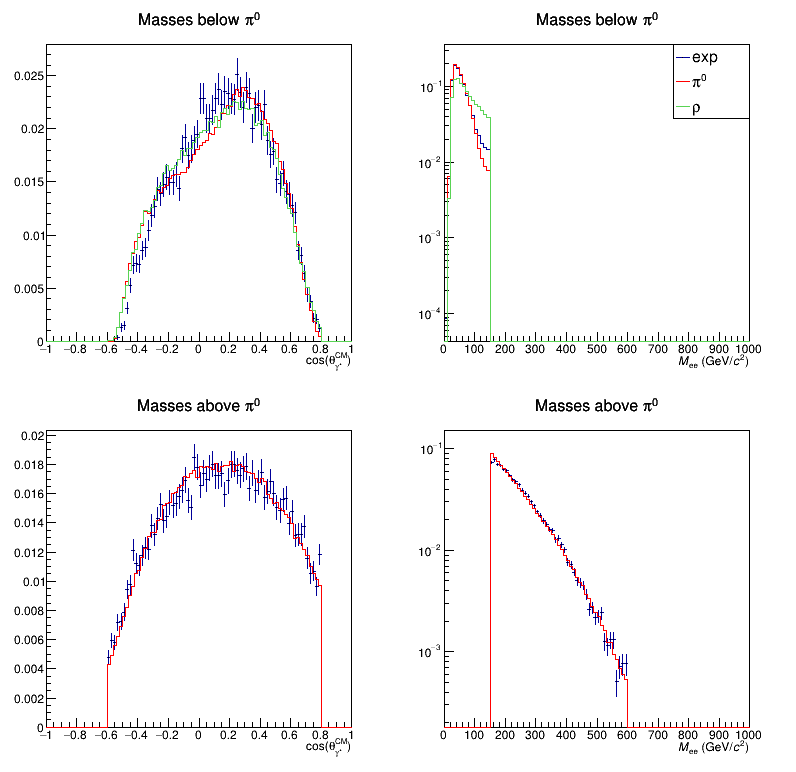

In [17]:
hmodelLowM_rho = histMakerMC_rho.makeHists((1.0))
hmodelLowM_rho[2][0].SetLineColor(8)
hmodelLowM_rho[1][0].SetLineColor(8)

hmodelLowM = histMakerMC_pi0.makeHists((1.0))

fraction = 0.25

hmodelLowM[2][0].Scale(1.0/hmodelLowM[2][0].Integral())
hmodelLowM[1][0].Scale(1.0/hmodelLowM[1][0].Integral())
hmodelLowM_rho[2][0].Scale(1.0/hmodelLowM_rho[2][0].Integral())
hmodelLowM_rho[1][0].Scale(1.0/hmodelLowM_rho[1][0].Integral())

hmodelLowM[2][0].Add(hmodelLowM_rho[2][0], fraction)
hmodelLowM[1][0].Add(hmodelLowM_rho[1][0], fraction)

hmodelLowM[2][0].SetLineColor(2)
hmodelLowM[1][0].SetLineColor(2)
hmodelHigM = getHistMakerMC(3).makeHists(1.0)
hmodelHigM[2][1].SetLineColor(2)
hmodelHigM[1][1].SetLineColor(2)

cc = TCanvas("cc","cc",800,800)
cc.Divide(2,2)
cc.Draw()

cc.cd(1)
dataScale = 1./histsData_np[2][0].Integral()
histsData_np[2][0].Scale(dataScale)
histsData_pp[2][0].Scale(dataScale)
histsData_nn[2][0].Scale(dataScale)
hmodelLowM[2][0].Scale(1./hmodelLowM[2][0].Integral())
hmodelLowM_rho[2][0].Scale(1./hmodelLowM_rho[2][0].Integral())
histsData_np[2][0].GetXaxis().SetTitle("cos(#theta^{CM}_{#gamma*})")
histsData_np[2][0].SetTitle("Masses below #pi^{0}")
histsData_np[2][0].Draw()
#histsData_pp[2][0].Draw("SAME")
#histsData_nn[2][0].Draw("SAME")
hmodelLowM[2][0].Draw("SAMEHIST")
hmodelLowM_rho[2][0].Draw("SAMEHIST")

pad = cc.cd(2)
pad.SetLogy()
histsData_np[1][0].Scale(1./histsData_np[1][0].Integral())
hmodelLowM[1][0].Scale(1./hmodelLowM[1][0].Integral())
hmodelLowM_rho[1][0].Scale(1./hmodelLowM_rho[1][0].Integral())
histsData_np[1][0].SetTitle("Masses below #pi^{0}")
histsData_np[1][0].GetXaxis().SetTitle("#it{M}_{ee} (GeV/#it{c}^{2})")
histsData_np[1][0].Draw("HIST")
hmodelLowM[1][0].Draw("SAMEHIST")
hmodelLowM_rho[1][0].Draw("SAMEHIST")

legend = TLegend(0.7, 0.7, 0.9, 0.9)
legend.AddEntry(histsData_np[1][0], "exp", "pl")
legend.AddEntry(hmodelLowM[1][0], "#pi^{0}", "l")
legend.AddEntry(hmodelLowM_rho[1][0], "#rho", "l")
legend.Draw()

cc.cd(3)
histsData_np[2][1].Scale(1./histsData_np[2][1].Integral())
hmodelHigM[2][1].Scale(1./hmodelHigM[2][1].Integral())
hmodelLowM_rho[2][1].Scale(1./hmodelLowM_rho[2][1].Integral())
histsData_np[2][1].GetXaxis().SetTitle("cos(#theta^{CM}_{#gamma*})")
histsData_np[2][1].SetTitle("Masses above #pi^{0}")
histsData_np[2][1].Draw()
hmodelHigM[2][1].Draw("SAMEHIST")
hmodelLowM_rho[2][1].Draw("SAMEHIST")

pad = cc.cd(4)
pad.SetLogy()
histsData_np[1][1].Scale(1./histsData_np[1][1].Integral())
hmodelHigM[1][1].Scale(1./hmodelHigM[1][1].Integral())
hmodelLowM_rho[1][1].Scale(1./hmodelLowM_rho[1][1].Integral())
histsData_np[1][1].GetXaxis().SetTitle("#it{M}_{ee} (GeV/#it{c}^{2})")
histsData_np[1][1].SetTitle("Masses above #pi^{0}")
histsData_np[1][1].Draw()
hmodelHigM[1][1].Draw("SAMEHIST")
hmodelLowM_rho[1][1].Draw("SAMEHIST")


#2 [[<cppyy.gbl.TH1F object at 0x2d5d25160>, <cppyy.gbl.TH1F object at 0x2d5d2e2d0>, <cppyy.gbl.TH1F object at 0x2d5d2e6c0>, <cppyy.gbl.TH1F object at 0x2d5d2eab0>, <cppyy.gbl.TH1F object at 0x2d5d2eea0>, <cppyy.gbl.TH1F object at 0x2d5d2fb40>, <cppyy.gbl.TH1F object at 0x2d5d2ff30>, <cppyy.gbl.TH1F object at 0x2d5d30320>, <cppyy.gbl.TH1F object at 0x2d5d30710>, <cppyy.gbl.TH1F object at 0x2d5d30b00>, <cppyy.gbl.TH1F object at 0x2d5d30ef0>, <cppyy.gbl.TH1F object at 0x2d5d312e0>], [<cppyy.gbl.TH1F object at 0x16994deb0>, <cppyy.gbl.TH1F object at 0x16994e690>], [<cppyy.gbl.TH1F object at 0x16994e2a0>, <cppyy.gbl.TH1F object at 0x16994ea80>]]
#2 [[<cppyy.gbl.TH1F object at 0x2c84967c0>, <cppyy.gbl.TH1F object at 0x2c8496bb0>, <cppyy.gbl.TH1F object at 0x2c8496fa0>, <cppyy.gbl.TH1F object at 0x2c8497390>, <cppyy.gbl.TH1F object at 0x2c8497780>, <cppyy.gbl.TH1F object at 0x2c8497b70>, <cppyy.gbl.TH1F object at 0x2c8497f60>, <cppyy.gbl.TH1F object at 0x2c8498350>, <cppyy.gbl.TH1F object at

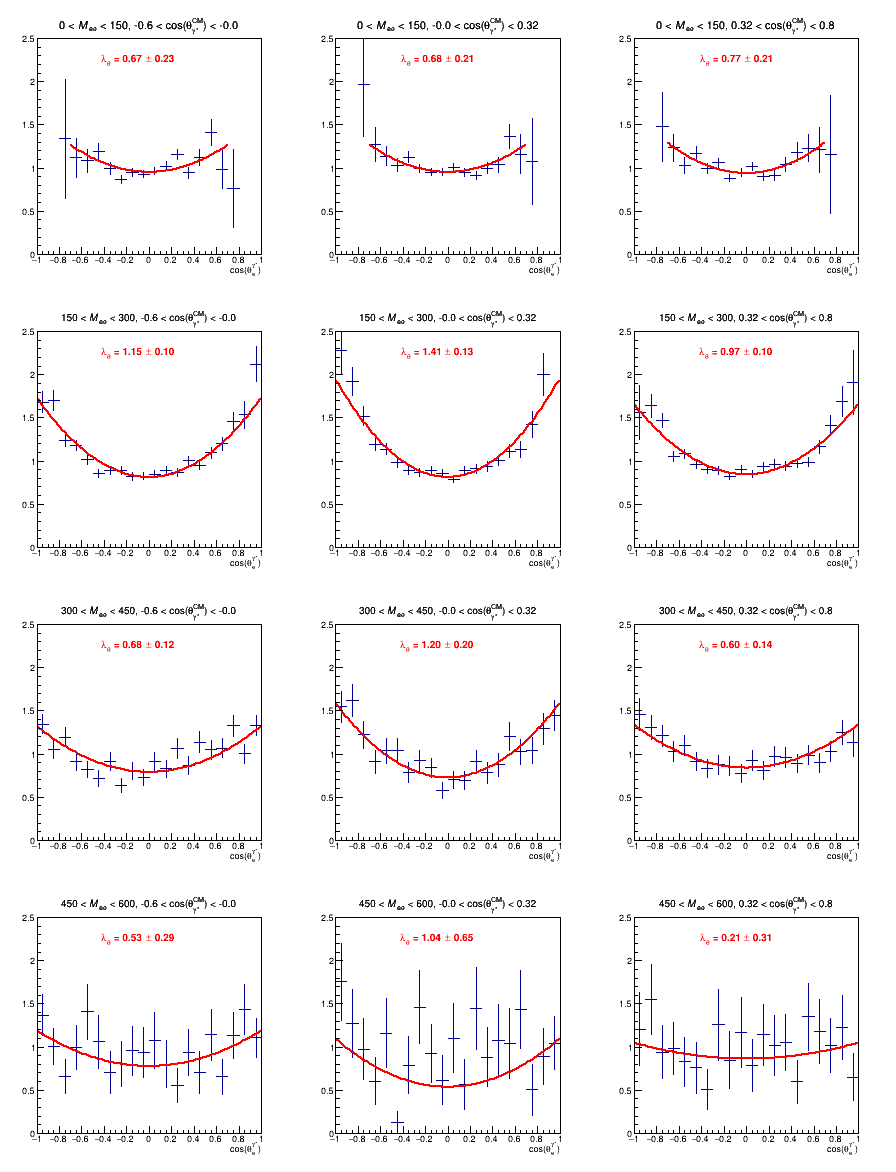

In [18]:
histsDataCorrs = []
hmodelLowM_null = histMakerMC_rho.makeHists((0.0))
hmodelLowM_null_pi0 = histMakerMC_pi0.makeHists((0.0))
pol2s = []
paveTexts = []

cc4 = TCanvas("cc4","cc4",900,1200)
cc4.Divide(3,4)
cc4.Draw()
for i, hist in enumerate(histsData_np[0]):

    cc4.cd(i+1)
    if not isinstance(hist, list):
        histCorr = hist.Clone(hist.GetName() + "_corr")
        histsDataCorrs.append(histCorr)
        histCorr.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        
        if i < 3:
            histCorr.Divide(hmodelLowM_null_pi0[0][i])
        else:
            histCorr.Divide(hmodelLowM_null[0][i])
       
        print(f"{i} creating fit function")
        fit = TF1(f"fit_{i}", "[0]*(1+[1]*x*x)",-1,1)
        fit.SetParameters(1, 1)
        
        if i < 3:
            histCorr.Fit(fit,"Q","", -0.7, 0.7)
        else:
            histCorr.Fit(fit,"Q")
        pol2s.append(fit)
            
        histCorr.Draw()
        histCorr.GetYaxis().SetRangeUser(0,2.5)
        histCorr.SetMinimum(0)

        caption = f"#lambda_{{#theta}} = {fit.GetParameter(1):.2f} #pm {fit.GetParError(1):.2f}"
        paveText = setOPT_text(caption, 0.25,0.76,0.675,0.88, 2, 0.04)
        paveTexts.append(paveText)
        
    else:
        print(hist)